In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.random_projection import GaussianRandomProjection
import sys

sys.path.append('../')
sys.path.append('../src/')
from src.generative import *
from src.detection import *
from src.utils import set_plotting_params

# MNIST - Encoded=True

In [2]:
mnist = MNIST(root='../data.nosync/').fit()
X = mnist.sample()
X_val = mnist.sample(10000, S='val')
X_test = mnist.sample(10000, S='test')

# print shapes
print('X:', X.shape)
print('X_val:', X_val.shape)
print('X_test:', X_test.shape)

X: (50000, 64)
X_val: (10000, 64)
X_test: (10000, 64)


## Synthetic Model

In [6]:
# q = rho * q_copying + (1 - rho) * q_underfit
copier = Memorizer(radius=0.05, n_copying=20)
underfitter = Memorizer(radius=0.5, n_copying=len(X)) 

m = 2*len(X) # number of samples to generate
k = 10 # number of random projections
lambdas = [5, 10, 20] 
d_proj = [1, 2, 3] # number of dimensions in the random projection
rhos = np.round(np.linspace(0, 1, 11), 2) # copying rate in the mixture model

In [8]:
for lam in lambdas: 
    results = np.zeros((m, k, len(d_proj), len(rhos))).astype(bool)

    for i, r in enumerate(tqdm(rhos)):
        q = Mixture(rho=r, q1=copier, q2=underfitter).fit(X)
        X1_gen = q.sample(m)
        X2_gen = q.sample(m)
        for j, d in enumerate(d_proj):
            for l in range(k):
                rp = GaussianRandomProjection(n_components=d).fit(X)
                dcd = DataCopyingDetector(lmbda=lam)
                idx = dcd.get_copying_indices(rp.transform(X), rp.transform(X1_gen), rp.transform(X2_gen))
                results[idx, l, j, i] = True

    # save results
    np.save(f'../doc/MNIST/mixed_model_results_lambda_{lam}.npy', results)

100%|██████████| 11/11 [17:18<00:00, 94.42s/it]


In [9]:
textwidth = set_plotting_params()
line_styles = ['--', '-.', ':']
colors = sns.color_palette('colorblind')
markers = ['x', '^', 'h', '^', 'v', '>', '<', 'p', '*', 'h']
markersize = [5, 4, 3, 2, 1]

fig, axs = plt.subplots(1, 3, figsize=(textwidth, 1.5), sharey=True)

for i, lam in enumerate(lambdas):
    results = np.load(f'../doc/MNIST/mixed_model_results_lambda_{lam}.npy')
    maj_votes = (results.mean(axis=1) > 0.5).mean(axis=0)
    # plot true copying rate
    axs[i].plot(rhos, rhos, label='True cr$_q$', linestyle='-', color='black')
    for j, d in enumerate(d_proj):
        axs[i].plot(rhos, maj_votes[j],
                    label='$d_{\\mathrm{proj}}=$' + str(d),
                    linestyle=line_styles[j],
                    color=colors[j],
                    marker=markers[j],
                    markersize=markersize[j],
                    alpha=0.75,
                )
    axs[i].set_xlabel('$\\rho$')
    axs[i].set_title(f'({chr(97 + i)})' + f' $\\lambda={lam}$', loc='center')
    axs[i].set_xticks(np.linspace(0, 1, 6))
    axs[i].set_yticks(np.linspace(0, 1, 6))


axs[0].set_ylabel('cr$_q$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=6)
plt.tight_layout(pad=0.3)
plt.savefig('../doc/MNIST/mixed_model_results.png', dpi=300)
plt.close()

## KDE

n.b. We fit the KDE model in the latent space.

In [6]:
m = int(1e6) # number of samples to generate
k = 10 # number of random projections
lambdas = [5, 10, 20]
d_proj = [1, 2, 3] # number of dimensions in the random projection
n_sigmas = 25 # number of sigmas to test
sigmas = np.logspace(-7, -2, n_sigmas)

In [7]:
# for lam in lambdas:
#     print(f'lambda={lam}')
#     results = np.zeros((m, k, len(d_proj), n_sigmas)).astype(bool)

#     for i, sigma in enumerate(tqdm(sigmas)):
#         q = KDE(bandwidth=sigma).fit(X)
#         X1_gen = q.sample(m)
#         X2_gen = q.sample(m)
#         for j, d in enumerate(d_proj):
#             for l in range(k):
#                 rp = GaussianRandomProjection(n_components=d).fit(X)
#                 dcd = DataCopyingDetector(lmbda=lam)
#                 idx = dcd.get_copying_indices(rp.transform(X), rp.transform(X1_gen), rp.transform(X2_gen))
#                 results[idx, l, j, i] = True


#     np.save(f'../doc/MNIST/kde_results_lambda_{lam}.npy', results)

In [8]:
### plot results
textwidth = set_plotting_params()
line_styles = ['--', '-.', ':']
colors = sns.color_palette('colorblind')
markers = ['x', '^', 'h', '^', 'v', '>', '<', 'p', '*', 'h']
markersize = [5, 4, 3, 2, 1]

fig, axs = plt.subplots(1, 3, figsize=(textwidth, 1.5), sharey=True)

for i, lam in enumerate(lambdas):
    results = np.load(f'../doc/MNIST/kde_results_lambda_{lam}.npy')
    maj_votes = (results.mean(axis=1) > 0.5).mean(axis=0)
    for j, d in enumerate(d_proj):
        axs[i].plot(sigmas, maj_votes[j],
                    label='$d_{\\mathrm{proj}}=$' + str(d),
                    linestyle=line_styles[j],
                    color=colors[j],
                    marker=markers[j],
                    markersize=markersize[j],
                    alpha=0.75,
                )
    axs[i].set_xlabel('$\\sigma$')
    axs[i].set_xscale('log')
    axs[i].set_title(f'({chr(97 + i)})' + f' $\\lambda={lam}$', loc='center')
    axs[i].set_yticks(np.linspace(0, 1, 6))



axs[0].set_ylabel('cr$_q$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.tight_layout(pad=0.3)
plt.savefig('../doc/MNIST/kde_results.png', dpi=300)
plt.close()

## Variational Autoencoder

In [3]:
m=int(1e5)
k=10
d_proj = [1, 2, 3] # number of dimensions in the random projection
lambdas = [5, 10, 20]
d_vals = np.arange(5, 105, 10)
n_vaes = len(d_vals)
d_vals

array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95])

In [4]:
# for lam in lambdas:
#     res_vae = np.zeros((m, k, len(d_proj), n_vaes)).astype(bool)

#     for i, d in enumerate(tqdm(d_vals)):
#         q = VAE(d=d)
#         q.fit(X, path=f'../data.nosync/trained_weights/VAE_d{d}.pkl')
#         X2 = q.sample(m)
#         X3 = q.sample(m)
#         for j, d in enumerate(d_proj):
#             for l in range(k):
#                 rp = GaussianRandomProjection(n_components=d).fit(X)
#                 dcd = DataCopyingDetector(lmbda=lam)
#                 idx = dcd.get_copying_indices(rp.transform(X), rp.transform(X2), rp.transform(X3))
#                 res_vae[idx, l, j, i] = True


#     np.save(f'../doc/MNIST/vae_results_lambda_{lam}.npy', res_vae)

In [5]:
### plot results
textwidth = set_plotting_params()
line_styles = ['--', '-.', ':']
colors = sns.color_palette('colorblind')
markers = ['x', '^', 'h', '^', 'v', '>', '<', 'p', '*', 'h']
markersize = [5, 4, 3, 2, 1]

fig, axs = plt.subplots(1, 3, figsize=(textwidth, 1.5), sharey=True)

for i, lam in enumerate(lambdas):
    results = np.load(f'../doc/MNIST/vae_results_lambda_{lam}.npy')
    maj_votes = (results.mean(axis=1) > 0.5).mean(axis=0)
    for j, d in enumerate(d_proj):
        axs[i].plot(d_vals, maj_votes[j],
                    label='$d_{\\mathrm{proj}}=$' + str(d),
                    linestyle=line_styles[j],
                    color=colors[j],
                    marker=markers[j],
                    markersize=markersize[j],
                    alpha=0.75,
                )
    axs[i].set_xlabel('$d_{\\mathrm{VAE}}$')
    axs[i].set_title(f'({chr(97 + i)})' + f' $\\lambda={lam}$', loc='center')
    axs[i].set_xticks(np.arange(0, 105, 20))
    axs[i].set_yticks(np.linspace(0, 1, 6))

axs[0].set_ylabel('cr$_q$')
low_y, _ = axs[0].get_ylim()
axs[0].set_ylim(low_y, 1)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')
plt.tight_layout(pad=0.3)
plt.savefig('../doc/MNIST/vae_results.png', dpi=300)
plt.close()

In [7]:
# set random seed
np.random.seed(41)

d = 5
q = VAE(d=d)
q.fit(X, path=f'../data.nosync/trained_weights/VAE_d{d}.pkl')
X_gen = q.sample(50000)
rp = GaussianRandomProjection(n_components=2).fit(X)
X_proj = rp.transform(X)
X_gen_proj = rp.transform(X_gen)


lambda_value = 2.5  # Set the value of lambda
x1 = np.linspace(0, 1, 1000)  # Range for Uniform(0, 1)
x2 = np.linspace(0, 1/lambda_value, 1000)  # Range for Uniform(0, 1/lambda)

textwidth = set_plotting_params()
colors = sns.color_palette('colorblind')

fig, axs = plt.subplots(1, 2, figsize=(textwidth, 2.5))
axs[1].scatter(X_proj[:, 0], X_proj[:, 1], label='Train', s=5, alpha=0.5, color=colors[0], marker='o')
axs[1].scatter(X_gen_proj[:, 0], X_gen_proj[:, 1], label='Generated', s=5, alpha=0.5, color=colors[1], marker='x')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].legend(fontsize='small')
axs[1].set_title('(b) 2-D Random Projection of VAE Samples', loc='center')

axs[0].fill_between(x1, 1, alpha=0.7, label=r'Uniform(0, 1)', color=colors[0])
axs[0].fill_between(x2, lambda_value, alpha=0.7, label=r'Uniform(0, $\frac{1}{\lambda}$)', color=colors[1])
axs[0].set_xticks([0, 1/lambda_value, 1], [r'0', r'$\frac{1}{\lambda}$', r'1'])
axs[0].set_yticks([0, 1, lambda_value], [r'0', r'1', r'$\lambda$'])
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$p(x)$')
axs[0].legend()
axs[0].set_title('(a) Underfitted Uniform Distribution', loc='center')

axs[0].grid(True)
plt.tight_layout(pad=0.5)
plt.savefig('../doc/Limitations/underfitted_uniform.png', dpi=300)
plt.close()

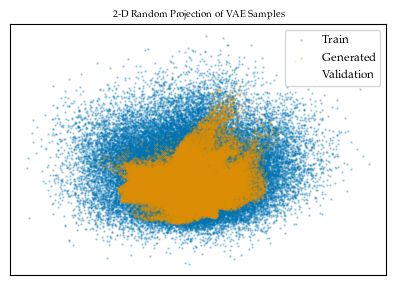

In [12]:
# produce single plot for 2-D random projection
np.random.seed(41)
X_val_proj = rp.transform(X_val)
textwidth = set_plotting_params()
colors = sns.color_palette('colorblind')

fig, ax = plt.subplots(1, 1, figsize=(0.7*textwidth, 0.5*textwidth))
ax.scatter(X_proj[:, 0], X_proj[:, 1], label='Train', s=0.5, alpha=0.3, color=colors[0], marker='o')
ax.scatter(X_gen_proj[:, 0], X_gen_proj[:, 1], label='Generated', s=0.5, alpha=0.3, color=colors[1], marker='x')
ax.scatter(X_val_proj[:, 0], X_val_proj[:, 1], label='Validation', s=0.5, alpha=0.3, color=colors[2], marker='s')
ax.set_xticks([])
ax.set_yticks([])
ax.legend(fontsize='large')
ax.set_title('2-D Random Projection of VAE Samples', loc='center')

plt.tight_layout(pad=0.5)
plt.savefig('../doc/Presentation/VAE.png', dpi=300)
plt.close()

# MNIST - Encoded=False

In [ ]:
mnist = MNIST(root='../data.nosync/').fit()
X = mnist.sample(encoded=False).detach().numpy().reshape(-1, 28*28)
X_val = mnist.sample(10000, S='val', encoded=False).detach().numpy().reshape(-1, 28*28)
X_test = mnist.sample(10000, S='test', encoded=False).detach().numpy().reshape(-1, 28*28)

# print shapes
print('X:', X.shape)
print('X_val:', X_val.shape)
print('X_test:', X_test.shape)


# plot 10 images
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axs[i].imshow(X[i].reshape(28, 28), cmap='gray')
    axs[i].axis('off')

## Synthetic Model

In [ ]:
# q = rho * q_copying + (1 - rho) * q_underfit
copier = Memorizer()
underfitter = Memorizer(radius=0.5, n_copying=len(X))
q = Mixture(rho=0.2, q1=copier, q2=underfitter).fit(X)

# plot a 10 samples drawn from q
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
samples = q.sample(10)
for i in range(10):
    axs[i].imshow(samples[i].reshape(28, 28), cmap='gray')
    axs[i].axis('off')

In [ ]:
# meehans test
tst = ThreeSampleDetector(num_regions=50)
tst.C_T(Q=q, X_train=X, X_test=X_val)

In [ ]:
X2 = q.sample(50000)
X3 = q.sample(50000)
print('X2:', X2.shape)
print('X3:', X3.shape)
k = 10
results = np.zeros((len(X3), k)).astype(bool)

for i in tqdm(range(k)):
    rp = GaussianRandomProjection(n_components=3).fit(X) # draw random projection
    dcd = DataCopyingDetector()
    idx = dcd.get_copying_indices(rp.transform(X), rp.transform(X2), rp.transform(X3))
    results[idx, i] = True

In [ ]:
print(f"Majortiy Voting: {(results.mean(axis=1) > 0.5).mean()}")
print(f"Mean Aggregation: {results.mean(axis=1).mean()}")
print(f"Set Aggregation: {(results.any(axis=1)).mean()}")